In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from models.HEGNN import HEGNN  
from rdkit.Chem import rdMolTransforms
#If using earlier than python3.9 version
from typing import Tuple, List


C:\Users\jonat\AppData\Local\Temp\ipykernel_24176\2440454210.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the data
train_df = pd.read_csv('Processed/Combined_Training.txt', sep = '\t')
val_df = pd.read_csv('Processed/Combined_Validate.txt', sep = '\t')
test_df =pd.read_csv('Processed/Combined_Test.txt', sep = '\t')

# While testing, only use the first 500 samples
# train_df = train_df.iloc[:500]
# val_df = val_df.iloc[:500]
# test_df = test_df.iloc[:500]


In [3]:
def balance_datasets(dataframe: pd.DataFrame) -> pd.DataFrame:

    """
    This filters the dataset to have a X:1 ratio of 0 value mols to 1 value mols
    Args:
        dataframe (pd.DataFrame): the dataset dataframe
    Return:
        pd.DataFrame: the filtered dataframe
    
    """
    function_one_df = dataframe[dataframe['Function'] == 1]
    function_zero_df = dataframe[dataframe['Function'] == 0]

    num_function_one = function_one_df.shape[0]

    # Calculate the number of rows to take from 'Function' == 0 (X:1 ratio)
    num_function_zero = min(1 * num_function_one, function_zero_df.shape[0]) #2* 

    balanced_function_zero_df = function_zero_df.sample(n=num_function_zero, random_state=42)
    balanced_train_df = pd.concat([function_one_df, balanced_function_zero_df])

    return balanced_train_df

In [4]:
train_df = balance_datasets(train_df)
val_df = balance_datasets(val_df)
test_df = balance_datasets(test_df)

In [5]:
torch.manual_seed(42)
np.random.seed(42)

In [6]:
from tqdm import tqdm
class MoleculeDataset(Dataset):
    """
    Custom Dataset for molecule data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing molecule data.
    """
    def __init__(self, dataframe: pd.DataFrame):
        self.data_list = []
        #self.smiles = None
        for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
            smiles = row['SMILE']
            label = row['Function']
            try:
                mol = Chem.MolFromSmiles(smiles)
            except:
                mol = None
                print(f'Failed to process SMILES: {smiles}')
            if mol is None:
                continue
            data = mol_to_graph_data(mol, smiles)
            if data is None:
                print("Data was None")
                continue
            data.y = torch.tensor([label], dtype=torch.float)
            self.data_list.append(data)

    def __len__(self) -> int:
        return len(self.data_list)

    def __getitem__(self, idx: int):
        return self.data_list[idx]

def atom_features(atom):
    """
    Returns a list of atom features.

    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        List[float]: List of features.
    """
    features = []
    features.append(atom.GetAtomicNum())
    features.append(atom.GetDegree())
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features.append(int(atom.GetHybridization()))
    features.append(int(atom.GetIsAromatic()))
    features.append(atom.IsInRing())
    features.append(int(atom.GetIsAromatic()))
    features.append(atom.GetMass())
    return features


# Function to check molecule validity
def is_valid_molecule(mol):
    """Sanity check for molecule validity after adding hydrogens."""
    try:
        Chem.SanitizeMol(mol)
        return True
    except Exception as e:
        print(f"Sanitization failed: {e}")
        return False


# Function to convert bond types to numeric values 
def bond_type_to_numeric(bond_type): 
     bond_mapping = {'SINGLE': 0, 'DOUBLE': 1, 'TRIPLE': 2, 'AROMATIC': 3} 
     return bond_mapping.get(bond_type, -1) 


# Function to calculate bond angles 
def calc_bond_angle(mol, atom1_idx, atom2_idx): 
     neighbors1 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom1_idx).GetNeighbors() if nbr.GetIdx() != atom2_idx] 
     neighbors2 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom2_idx).GetNeighbors() if nbr.GetIdx() != atom1_idx] 
     if neighbors1 and neighbors2: 
         return rdMolTransforms.GetAngleDeg(mol.GetConformer(), neighbors1[0], atom1_idx, atom2_idx)
     return None 


# Function to check if a bond is rotatable 
def is_rotatable_bond(bond): 
     if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
         return False 
     return (not bond.GetBeginAtom().IsInRing() and bond.GetBeginAtom().GetDegree() > 1 and 
             not bond.GetEndAtom().IsInRing() and bond.GetEndAtom().GetDegree() > 1)


# Conformer generation with fallback 
def generate_conformer(mol, max_attempts=1000): 
     params = AllChem.ETKDG()
     params.maxAttempts = max_attempts
     try: 
         success = AllChem.EmbedMolecule(mol, params)
         if success == -1: 
             return None  # Failed to generate conformer 
         try: 
             AllChem.UFFOptimizeMolecule(mol) 
         except ValueError: 
             if not AllChem.MMFFOptimizeMolecule(mol): 
                 return None 
     except Exception as e: 
         print(f'Conformer generation error: {e}') 
         return None 
     return mol 




def mol_to_graph_data(mol: Chem.Mol, smiles_name) -> Data:
    """
    Converts an RDKit Mol object to a PyTorch Geometric Data object.

    Args:
        mol (Chem.Mol): RDKit molecule object.

    Returns:
        data (Data): PyTorch Geometric Data object.
    """
    # Add hydrogens and generate 3D coordinates
    mol = Chem.AddHs(mol)
    if not is_valid_molecule(mol):  # Validate molecule after adding Hs
        print(f"Invalid molecule after adding hydrogens: {smiles_name}")
        return None
    
    mol = generate_conformer(mol)
    if mol is None:
        return None
    
    # Nodes
    node_feats = []
    node_positions = []
    for atom in mol.GetAtoms():
        node_feats.append(atom_features(atom))
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        node_positions.append([pos.x, pos.y, pos.z])
    node_feats = torch.tensor(node_feats, dtype=torch.float)
    node_positions = torch.tensor(node_positions, dtype=torch.float)
    
    # Edges
    edge_index = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])  # Undirected
        
        bond_type_numeric = bond_type_to_numeric(str(bond.GetBondType()))
        bond_angle = calc_bond_angle(mol, i, j)
        rotatable = is_rotatable_bond(bond)

        atom1_type = mol.GetAtomWithIdx(i).GetAtomicNum()
        atom2_type = mol.GetAtomWithIdx(j).GetAtomicNum()

        edge_attrs.extend([
            [bond_type_numeric, bond_angle or 0.0, int(rotatable), atom1_type, atom2_type],
            [bond_type_numeric, bond_angle or 0.0, int(rotatable), atom2_type, atom1_type]  # Reverse direction
    ])
        
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attrs = torch.tensor(edge_attrs, dtype=torch.float)
    
    # Node velocities as small random values
    node_velocities = torch.randn_like(node_positions) * 0.01
    
    data = Data(
        x=node_feats,
        pos=node_positions,
        vel=node_velocities,
        edge_index=edge_index,
        edge_attr=edge_attrs,
        smiles=smiles_name
    )
    return data


In [7]:
# Create datasets
train_dataset = MoleculeDataset(train_df)
val_dataset = MoleculeDataset(val_df)
test_dataset = MoleculeDataset(test_df)

# Create DataLoaders
batch_size = 32
print(f"Number of training samples: {len(train_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Number of validation samples: {len(val_dataset)}")
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print(f"Number of test samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=batch_size)


 27%|██▋       | 113/422 [00:22<00:37,  8.14it/s][09:49:21] UFFTYPER: Warning: hybridization set to SP3 for atom 20
[09:49:21] UFFTYPER: Warning: hybridization set to SP3 for atom 20
 55%|█████▍    | 231/422 [00:34<00:06, 30.10it/s]

Data was None


  3%|▎         | 3/90 [00:00<00:06, 14.14it/s]

Data was None


100%|██████████| 92/92 [00:09<00:00,  9.58it/s]

Number of training samples: 421
Number of validation samples: 89
Number of test samples: 92


In [8]:
# Initialize the HEGNN model and classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
num_layers = 3
mol = Chem.MolFromSmiles('CCO')
node_input_dim = len(atom_features(mol.GetAtomWithIdx(0)))
edge_attr_dim = 5   # Bond type, angle, rotatable, atom1, atom2
hidden_dim = 64
max_ell = 2  # Example value

# Initialize the HEGNN
heg_nn = HEGNN(
    num_layer=num_layers,
    node_input_dim=node_input_dim,
    edge_attr_dim=edge_attr_dim,
    hidden_dim=hidden_dim,
    max_ell=max_ell,
    activation=nn.SiLU(),
    device=device
).to(device)

class HEGNNClassifier(nn.Module):
    """
    Model that combines HEGNN and a linear classifier.

    Args:
        heg_nn (HEGNN): The HEGNN model.
        hidden_dim (int): Dimension of the HEGNN output.
    """
    def __init__(self, heg_nn: HEGNN, hidden_dim: int):
        super(HEGNNClassifier, self).__init__()
        self.heg_nn = heg_nn
        self.classifier = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        node_feat = data.x
        node_pos = data.pos
        node_vel = data.vel
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        node_embeddings = self.heg_nn(node_feat, node_pos, node_vel, edge_index, edge_attr)
        graph_embeddings = global_mean_pool(node_embeddings, batch)
        out = self.classifier(graph_embeddings)
        return out, graph_embeddings

# Initialize the classifier model
model = HEGNNClassifier(heg_nn, hidden_dim).to(device)


In [9]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
def train(model: nn.Module, loader: DataLoader) -> float:
    """
    Training loop for one epoch.

    Args:
        model (nn.Module): The model to train.
        loader (DataLoader): DataLoader for training data.

    Returns:
        float: Average loss over the epoch.
    """
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, _ = model(data)
        label = data.y.view(-1, 1)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


In [11]:
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Evaluation loop.

    Args:
        model (nn.Module): The model to evaluate.
        loader (DataLoader): DataLoader for validation or test data.

    Returns:
        Tuple[float, np.ndarray, np.ndarray]: Average loss, predictions, and labels.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, _ = model(data)
            label = data.y.view(-1, 1)
            loss = criterion(out, label)
            total_loss += loss.item() * data.num_graphs
            preds = torch.sigmoid(out).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


In [12]:
def get_accuracy(predictions: np.ndarray, labels: np.ndarray) -> float:
    """
    Converts sigmoid prediction to binary values and computes accuracy

    Args: 
        predictions (np.ndarray): Sigmoid prediction values
        labels (np.ndarray): True binary labels

    Returns:
        float: The accuracy score
    """

    binary_preds = []
    for prediction in predictions:
        if prediction >= .5:
            binary_preds.append(1)
        else:
            binary_preds.append(0)
    binary_preds = np.array(binary_preds)
    accuracy = accuracy_score(binary_preds, labels)

    return accuracy

In [13]:
# Training loop execution
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader)
    val_loss, val_preds, val_labels = evaluate(model, val_loader)

    val_accuracy = get_accuracy(val_preds, val_labels)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1, Train Loss: 0.6947, Validation Loss: 0.6939, Validation Accuracy: 0.4944
Epoch 2, Train Loss: 0.6936, Validation Loss: 0.6929, Validation Accuracy: 0.4944
Epoch 3, Train Loss: 0.6931, Validation Loss: 0.6918, Validation Accuracy: 0.5730
Epoch 4, Train Loss: 0.6942, Validation Loss: 0.6897, Validation Accuracy: 0.5843
Epoch 5, Train Loss: 0.6850, Validation Loss: 0.6774, Validation Accuracy: 0.5506
Epoch 6, Train Loss: 0.6795, Validation Loss: 0.6801, Validation Accuracy: 0.5730
Epoch 7, Train Loss: 0.6764, Validation Loss: 0.6761, Validation Accuracy: 0.5281
Epoch 8, Train Loss: 0.6681, Validation Loss: 0.6691, Validation Accuracy: 0.5056
Epoch 9, Train Loss: 0.6637, Validation Loss: 0.6704, Validation Accuracy: 0.5393
Epoch 10, Train Loss: 0.6638, Validation Loss: 0.6722, Validation Accuracy: 0.5056
Epoch 11, Train Loss: 0.6627, Validation Loss: 0.6713, Validation Accuracy: 0.5618
Epoch 12, Train Loss: 0.6588, Validation Loss: 0.6836, Validation Accuracy: 0.5506
Epoch 13, Tra

In [14]:
for val in val_preds:
    if val > .50:
        print(val)
print(val_preds[0:10])

[0.5592199]
[0.5337256]
[0.5716464]
[0.5649266]
[0.5554677]
[0.50822866]
[0.5565939]
[0.5287893]
[0.5057573]
[0.5670783]
[0.6506488]
[0.5271779]
[0.5017487]
[0.54499006]
[0.5068753]
[0.5033194]
[0.60537165]
[0.57264394]
[0.5903739]
[0.5241701]
[0.67999274]
[0.5915157]
[0.50461364]
[0.56572235]
[0.6449547]
[0.5840492]
[0.8531823]
[0.50163096]
[0.5279985]
[0.53342277]
[0.5329136]
[0.53446877]
[0.51817256]
[0.53259474]
[0.53271735]
[0.5525939]
[0.57400924]
[0.56437284]
[0.83175015]
[0.75373924]
[0.52471566]
[0.5439688]
[0.5408218]
[[0.46411127]
 [0.01354533]
 [0.47101387]
 [0.5592199 ]
 [0.3697333 ]
 [0.46608877]
 [0.5337256 ]
 [0.5716464 ]
 [0.24441986]
 [0.5649266 ]]


In [15]:
def get_embeddings_and_labels(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extracts graph embeddings and labels from the model.

    Args:
        model (nn.Module): The trained model.
        loader (DataLoader): DataLoader for the dataset.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Embeddings and labels.
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, graph_embeddings = model(data)
            embeddings.append(graph_embeddings.cpu())
            labels.append(data.y.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings.numpy(), labels.numpy()


In [16]:
# Get embeddings and labels
train_embeddings, train_labels = get_embeddings_and_labels(model, train_loader) 
val_embeddings, val_labels = get_embeddings_and_labels(model, val_loader)
test_embeddings, test_labels = get_embeddings_and_labels(model, test_loader)


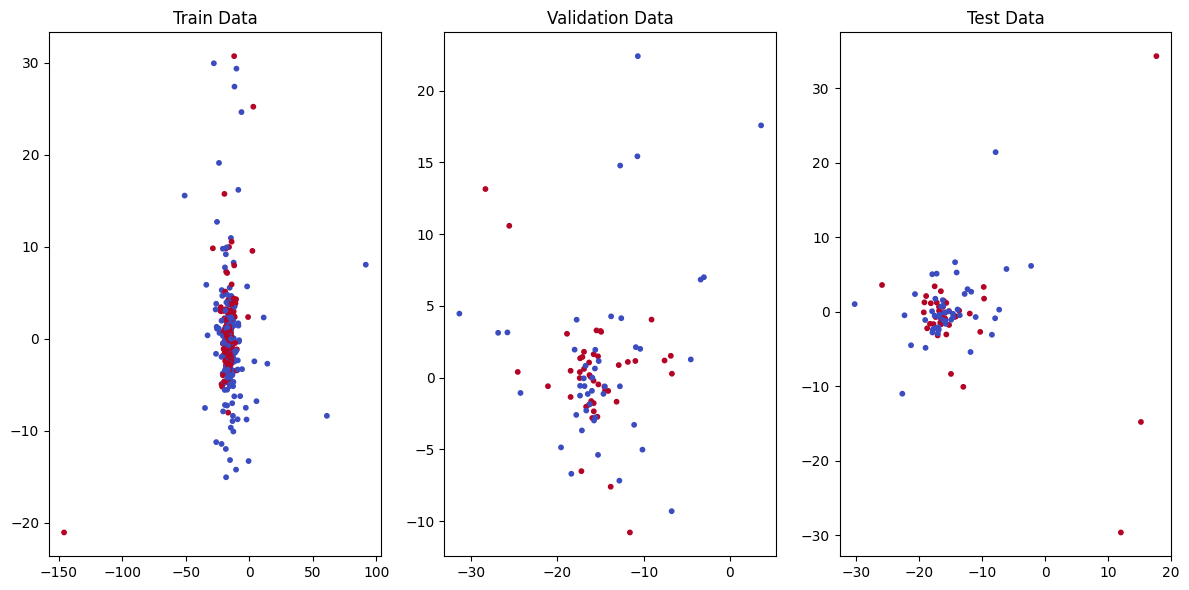

In [17]:

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings)
val_pca = pca.transform(val_embeddings)
test_pca = pca.transform(test_embeddings)

# Remove major outliers for better visualization from PCA and labels
x_mean = np.mean(train_pca[:, 0])
x_std = np.std(train_pca[:, 0])
y_mean = np.mean(train_pca[:, 1])
y_std = np.std(train_pca[:, 1])

# Prune outliers down to 1 standard deviation from the mean
pruned_train_pca = train_pca[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                             (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]
pruned_train_labels = train_labels[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                                   (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]

pruned_val_pca = val_pca[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                            (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]
pruned_val_labels = val_labels[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                                (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]

pruned_test_pca = test_pca[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                            (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]
pruned_test_labels = test_labels[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                                (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]


# Plot PCA embeddings
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(pruned_train_pca[:, 0], pruned_train_pca[:, 1], c=pruned_train_labels, cmap='coolwarm', s=10)
plt.title('Train Data')
plt.subplot(1, 3, 2)
plt.scatter(pruned_val_pca[:, 0], pruned_val_pca[:, 1], c=pruned_val_labels, cmap='coolwarm', s=10)
plt.title('Validation Data')
plt.subplot(1, 3, 3)
plt.scatter(pruned_test_pca[:, 0], pruned_test_pca[:, 1], c=pruned_test_labels, cmap='coolwarm', s=10)
plt.title('Test Data')
plt.tight_layout()
plt.show()



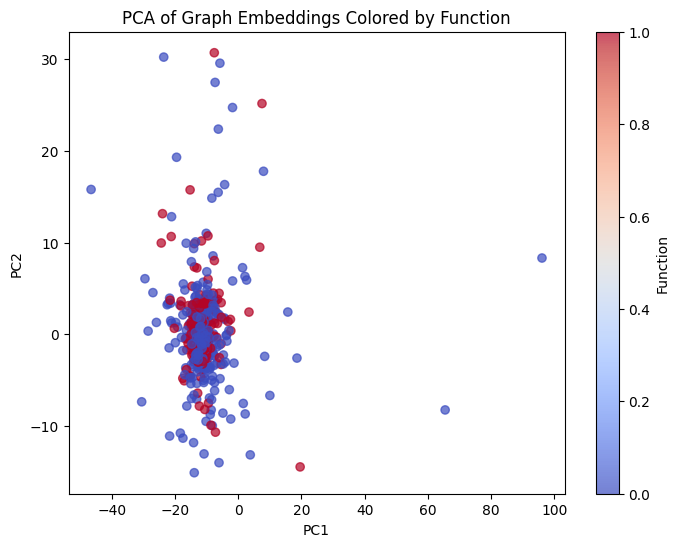

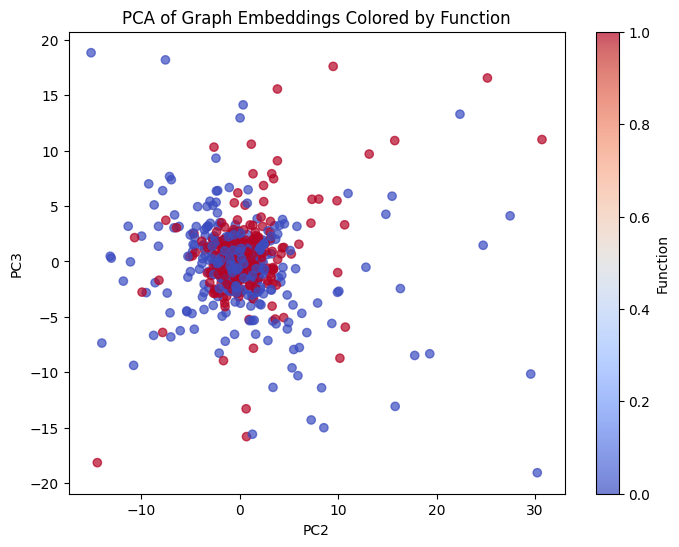

In [18]:
# Perform PCA and plot embeddings
from sklearn.decomposition import PCA

# Combine embeddings and labels
all_embeddings = np.concatenate([train_embeddings, val_embeddings, test_embeddings], axis=0)
all_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Prune outliers down to 1 standard deviation from the mean
x_mean = np.mean(pca_result[:, 0])
x_std = np.std(pca_result[:, 0])
y_mean = np.mean(pca_result[:, 1])
y_std = np.std(pca_result[:, 1])
z_mean = np.mean(pca_result[:, 2])
z_std = np.std(pca_result[:, 2])

# Prune outliers down to 1 standard deviation from the mean
pruned_pca_result = pca_result[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                               (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                                 (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]
pruned_labels = all_labels[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                            (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                            (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 0], pruned_pca_result[:, 1], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()

# Also plot PCA2 and PCA3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 1], pruned_pca_result[:, 2], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()


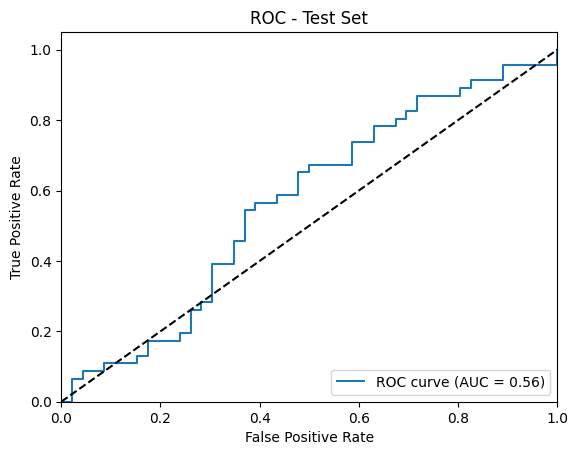

In [19]:
# Train a linear classifier on the embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare training and test data
X_train = train_embeddings
y_train = train_labels.squeeze()
X_test = test_embeddings
y_test = test_labels.squeeze()

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test Set')
plt.legend(loc='lower right')
plt.show()


Testing accuracy: 0.5761


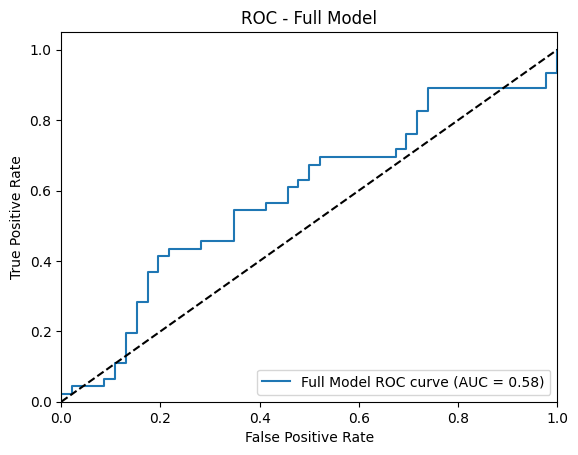

In [20]:
# Evaluate the full model on the test set and plot ROC curve
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out, _ = model(data)
        preds = torch.sigmoid(out).cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

accuracy = get_accuracy(all_preds, all_labels)
print(f"Testing accuracy: {accuracy:.4f}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Full Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Full Model')
plt.legend(loc='lower right')
plt.show()


In [21]:
for val in preds:
    if val > .3:
        print(val)
#print(preds[0:10])

[0.35492912]
[0.47096598]
[0.50445753]
[0.4432189]
[0.5041616]
[0.4777412]
[0.5657003]
[0.502642]
[0.4130082]
[0.6106322]
[0.581973]
[0.46566162]
[0.54999274]
[0.46148425]
[0.49919727]
[0.51464003]
[0.63543695]
[0.6512282]
[0.5320693]
[0.47922975]
[0.4758329]


In [22]:
def get_smiles_vocab(train_df: pd.DataFrame) -> list:
    """
    Obtain all unique SMILES characters for our vocabulary
    Args: 
        trainData (DataFrame): Original training data

    Returns:
        list: The vocabulary list
    """
    vocabulary_set = set()
    vocabulary = []
    for index, row, in train_df.iterrows():
        #print(row)
        smiles = (row["SMILE"])
        for chr in smiles:
            #print(chr)
            if chr not in vocabulary_set:
                vocabulary_set.add(chr)
                vocabulary.append(chr)
            
    return vocabulary



In [23]:
#We may want to filter out some of these vocab elements, like the "." bc I thought we got rid of those?
smiles_chars = get_smiles_vocab(train_df)
print(smiles_chars)
char_to_idx = {char: idx for idx, char in enumerate(smiles_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

char_to_idx[' '] = len(char_to_idx)  # Assign a new index for padding
idx_to_char[len(idx_to_char)] = ' '

#We try to ignore the padding later, so potentially -1?
vocab_size = len(char_to_idx)#len(smiles_chars) +1 padding chr
print(f"Length of vocabulary is {vocab_size}")

['[', 'H', ']', 'C', '@', '1', '2', '(', 'O', ')', '=', '3', 'l', '4', '5', 'F', 'N', '#', 'S', 'B', 'r', '\\', '/', '-', '+', '6', '7', '8', 'P', 'A', 's', 'I', 'i', 'g', 'n']
Length of vocabulary is 36


In [24]:
def encode_smiles(smiles: str) -> list:
    """
    Encodes SMILES strings to a list of indices.
    Args: 
        smiles (str): A SMILES string

    Returns:
        list: the SMILES string encoded
    
    """
    return [char_to_idx[char] for char in smiles]

def decode_indices(indices: list) -> str:
    """
    Decodes a list of indices back to a SMILES string.
    Args: 
        indicies (list): list of encoded SMILES string

    Returns:
        list: the decoded SMILES string
    
    """
    return ''.join([idx_to_char[idx] for idx in indices])

In [25]:
def get_vae_training_data(train_embeddings: np.ndarray, train_labels: np.ndarray) -> np.ndarray:
    """
    Obtain the embeddings of training samples that activate AR
    Args:
        train_embeddings (np.ndarray): the training embeddings
        train_labels (np.ndarray): binary activation labels for the embedded samples

    Return:
    np.ndarray: the activating embeddings
    
    """
    activating_embeddings = []
    for i, label in enumerate(train_labels):
        if label == 1:
            embedding = train_embeddings[i]
            activating_embeddings.append(embedding)
    
    activating_embeddings = np.array(activating_embeddings)
    return activating_embeddings 



In [26]:
def pad_smiles_indices(smiles_indices: List[List], padding_value=char_to_idx[' ']) -> torch.tensor:
    """
    Pads sequences with the padding character index, since the SMILES strings are different lengths
    
    Args:
        smiles_indices (list[list]): the list of mapped indices for SMILES strings
    Return: 
        torch.tensor

    """
    padded_smiles = pad_sequence([torch.tensor(smi, dtype=torch.long) for smi in smiles_indices],
                                 batch_first=True,
                                 padding_value=padding_value)
    return padded_smiles

In [27]:
def get_smiles_with_y_equals_one(data_loader: DataLoader) -> np.ndarray:
    """
    Pads sequences with the padding character index, since the SMILES strings are different lengths
    
    Args:
        data_loader (DataLoader): the unshuffled dataloader
    Return: 
        np.ndarray: the list of SMILES that activate AR (in order)

    """
    smiles_list = []
    for data in data_loader:
        for i in range(len(data.smiles)):
            if data.y[i].item() == 1:  # Check if y value is 1
                smiles_list.append(data.smiles[i])
    smiles_list = np.array(smiles_list)
    return smiles_list

In [28]:
# The goal of this section is to get the SMILES strings from the embeddings for molecules that activate the AR, so we can pass in both of those to decoder to learn. 

#Keep shuffle=False
train_loader_vae = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

smiles_with_y_one = get_smiles_with_y_equals_one(train_loader_vae)
train_embeddings_unshuffled, train_labels_unshuffled = get_embeddings_and_labels(model, train_loader_vae) 
train_embeddings_with_y_one = get_vae_training_data(train_embeddings_unshuffled, train_labels_unshuffled)

vae_train_smiles_indices = [encode_smiles(smile) for smile in smiles_with_y_one]
padded_vae_train_smiles_indices = pad_smiles_indices(vae_train_smiles_indices)

In [29]:
top = 0
for sm in vae_train_smiles_indices:
    length = len(sm)
    if length > top:
        top = length

print(top)

202


In [30]:
padded_vae_train_smiles_indices[0]

tensor([ 0,  1,  2,  0,  3,  4,  4,  2,  5,  6,  3,  3,  0,  3,  4,  2,  7,  8,
         3,  7,  3,  9, 10,  8,  9,  7,  3,  7,  3,  9, 10,  8,  9,  0,  3,  4,
         4,  2,  5,  7,  3,  9,  3,  3,  0,  3,  4,  4,  2, 11,  7,  0,  1,  2,
         9,  0,  3,  4,  4,  2,  6,  7,  0,  1,  2,  9,  3, 10,  3,  7,  3, 12,
         9,  3, 13, 10,  3,  3,  7, 10,  8,  9,  3,  3,  0,  3,  4,  2, 11, 13,
         3, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35])

In [31]:
train_dataset_vae_with_y_one = TensorDataset(torch.tensor(train_embeddings_with_y_one, dtype=torch.float32),
                              torch.tensor(padded_vae_train_smiles_indices, dtype=torch.long))

#NOTE: set shuffle=True once code works eventually
train_loader_vae_with_y_one = DataLoader(train_dataset_vae_with_y_one, batch_size=32, shuffle=False)


C:\Users\jonat\AppData\Local\Temp\ipykernel_24176\1647618880.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(padded_vae_train_smiles_indices, dtype=torch.long))


In [32]:
train_dataset_vae_with_y_one[0]

(tensor([1.3377, 1.6623, 4.6930]),
 tensor([ 0,  1,  2,  0,  3,  4,  4,  2,  5,  6,  3,  3,  0,  3,  4,  2,  7,  8,
          3,  7,  3,  9, 10,  8,  9,  7,  3,  7,  3,  9, 10,  8,  9,  0,  3,  4,
          4,  2,  5,  7,  3,  9,  3,  3,  0,  3,  4,  4,  2, 11,  7,  0,  1,  2,
          9,  0,  3,  4,  4,  2,  6,  7,  0,  1,  2,  9,  3, 10,  3,  7,  3, 12,
          9,  3, 13, 10,  3,  3,  7, 10,  8,  9,  3,  3,  0,  3,  4,  2, 11, 13,
          3, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35]))

EVERYWHERE BELOW HERE IS PROBLEMATIC

In [33]:
#NOTE: THIS WHOLE CLASS SHOULD PROB GET DELETED AND REWORKED

class LSTMDecoder(nn.Module):
    """
    Model that decodes from a latent space

    Args:
        latent_dim (int): the dimensionality of the input embeddings
        hidden_dim (int): transforming inputs to different dimension
        vocab_size (int): number of unique characters in our SMILES vocab
        num_layers (int): depth of decoder
    """
    def __init__(self, latent_dim, hidden_dim, vocab_size, num_layers=2):
        super(LSTMDecoder, self).__init__()
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    #NOTE: THIS IS NOT CORRECT
    #Reduce max_length? the max length for a SMILES is in 80s i think
    def forward(self, z, max_length=100): #100
        batch_size = z.size(0)
        hidden = self.latent_to_hidden(z).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        input_token = torch.zeros(batch_size, 1, vocab_size)  # Start token, adjust as needed
        outputs = []

        for _ in range(max_length):
            output, (hidden, cell) = self.lstm(input_token, (hidden, cell))
            output_token = self.output_layer(output[:, -1, :])

            #eos_token = output_token.argmax(dim=-1)
            #print(eos_token)

            #print(output_token.shape)
            #print("----")
            outputs.append(output_token)
            #print(output_token.shape)
            input_token = F.one_hot(output_token.argmax(dim=-1), num_classes=vocab_size).float().unsqueeze(1)
            #print(input_token.)

        return torch.cat(outputs, dim=1)

In [34]:
class VAE(nn.Module):
    """
    Variational Autoencoder that only decodes an input sample

    Args:
        deocder (nn.Module): A decoder for the VAE
    """
    def __init__(self, decoder):
        super(VAE, self).__init__()
        self.decoder = decoder

    def sample(self, num_samples=1, latent_dim=3):
        #Sample from a standard normal distribution
        z = torch.randn(num_samples, latent_dim)
        return self.decoder(z)

In [35]:
# Set hyperparameters for deocder
latent_dim = 3  #Dimension of the 3D embeddings from the GNN
hidden_dim = 256
decoder = LSTMDecoder(latent_dim, hidden_dim, vocab_size)
vae = VAE(decoder)

criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx[' '])
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [36]:
"""
We are feeding in only activating samples to the VAE
"""
vae.train()
for epoch in range(3):
    for batch_embeddings, batch_smiles in train_loader_vae_with_y_one: 
        #print(batch_smiles)
        #break
        optimizer.zero_grad()
        outputs = vae.decoder(batch_embeddings, max_length=batch_smiles.size(1))
        loss = criterion(outputs.view(-1, vocab_size), batch_smiles.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 3.1699602603912354
Epoch 2, Loss: 2.46252703666687
Epoch 3, Loss: 2.411515474319458


In [37]:
vae.eval()
with torch.no_grad():
    sampled_smiles = vae.sample(num_samples=1)


In [38]:
sampled = sampled_smiles.tolist()[0][0:100]
print(sampled)

[1.20388925075531, 0.6801210045814514, 0.7036436796188354, 1.2069098949432373, 0.5924270749092102, 0.3956810235977173, 0.13666942715644836, 0.49810200929641724, 0.36794957518577576, 0.4381219446659088, 0.4655025601387024, 0.15685828030109406, -0.4821528494358063, 0.04304622858762741, -0.6099379062652588, -0.5497995615005493, -0.09297990798950195, -0.789183497428894, -0.7772569060325623, -0.753078043460846, -0.7688369154930115, -0.5354377031326294, -0.9213047027587891, -0.7263316512107849, -0.8237795233726501, -0.7723082900047302, -1.0181667804718018, -0.8789186477661133, -0.8243120312690735, -0.7239360213279724, -0.799172043800354, -0.8266965746879578, -0.9164870977401733, -1.1223289966583252, -0.7750403881072998, -0.8042405843734741, 1.2786900997161865, 0.8821171522140503, 1.1042170524597168, 1.82900869846344, 1.0966198444366455, 0.6520280838012695, 0.506711483001709, 1.056983232498169, 0.6689575910568237, 0.9810394644737244, 0.8768019080162048, 0.32641854882240295, -0.891659855842590

In [39]:
print(len(sampled))

100


In [40]:
print(min(sampled))
print(max(sampled))


-1.9777358770370483
2.4328458309173584


In [41]:
def scale_list(numbers, max_length):
    min_val = min(numbers)
    max_val = max(numbers)
    
    scaled_numbers = [(x - min_val) / (max_val - min_val) * max_length for x in numbers]
    scaled_numbers = [int(x) for x in scaled_numbers]
    
    return scaled_numbers

In [42]:
tmp = scale_list(sampled, 42)

In [43]:
for i, val in enumerate(tmp):
    if val > 40:
        print(i)
        print(val)
        #print(val)

75
42


In [44]:
example = decode_indices(tmp)
print(example)
molecule = Chem.MolFromSmiles(example)
if molecule:
    print("Molecule successfully created")
else:
    print("Invalid SMILES string")

KeyError: 36